<a href="https://colab.research.google.com/github/MpRonald/C/blob/main/Scrip_TCC_Decision_Tree_dados_balanceados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Local onde foi baixado o dataset<br>
https://archive.ics.uci.edu/ml/machine-learning-databases/00222/
<br>
#### Link do raw do GitHub<br>
https://raw.githubusercontent.com/MpRonald/TCC/main/bank-full.csv

In [1]:
# conectando o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import pydot # 0.5
import graphviz # 0.5

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, plot_confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score, mean_squared_error, precision_score, confusion_matrix)
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# lendo dataset (diponível no GitHub) **
url = 'https://raw.githubusercontent.com/MpRonald/datasets/main/bank-full.csv'
dataset = pd.read_csv(url, sep=';')
data = dataset.drop(['duration'], axis=1)
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,1,-1,0,unknown,no


_______________________________________________________________________
# Dados do cliente do banco:
*  1 - age: Idade do cliente
*  2 - job: Tipo de trabalho ("admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
*  3 - marital: Estado Civil ("divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
*  4 - education: Escolaridade ("basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
*  5 - default: Inadimplência, tem crédito inadimplente? ("no", "yes", "unknown")
*  6 - balance: saldo da conta do cliente
*  7 - housing: Habitação: tem crédito habitação? ("no","yes","unknown")
*  8 - loan: Empréstimo, tem empréstimo pessoal? ("no", "yes", "unknown")

# Relacionado com o último contato da campanha atual:
*  9 - contact: contato, tipo de comunicação de contato ("cellular","telephone")
*  10 - month: mês, último mês de contato do ano ("jan", "feb", "mar", ..., "nov", "dec")
*  11 - day: Dia do Mês, último dia de contato do mês(1, 2, 3 ... 29, 30, 31)
*  12 - duration: duração, duração do último contato, em segundos. Observação importante: esse atributo afeta muito o destino de saída (por exemplo, se duração=0, então y="no"). No entanto, a duração não é conhecida antes de uma chamada ser realizada. Além disso, após o término da chamada, y é obviamente conhecido. Assim, essa entrada deve ser incluída apenas para fins de benchmark e deve ser descartada se a intenção for ter um modelo preditivo realista.

# Outros Atributos:
*  13 - campaign: campanha, número de contatos realizados durante esta campanha e para este cliente(inclui último contato)
*  14 - pdays: número de dias que se passaram após o último contato com o cliente de uma campanha anterior (-1 significa que o cliente não foi contatado anteriormente)
*  15 - previous: número de contatos realizados antes desta campanha e para este cliente 
*  16 - poutcome: resultado da campanha de marketing anterior ("failure","nonexistent","success")
  
# Variável de saída (destino desejado):
*  17 - y: o cliente atrasou um depósito a prazo? (binário: "sim", "não")

_______________________________________________________________________
<font size=6 color='white' font ><b>Analise Exploratória de Dados



# Verificando dataframe

In [4]:
# verificando o numero de colunas e linhas**
data.shape

(45211, 16)

In [5]:
# verificando os nomes das colunas**
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')

In [6]:
# verificando media, desvio padrao, menor valor, quartis, maior valor de cada coluna numérica**
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


### Verificando a existência de OutLiers



In [7]:
data['pdays'].value_counts()

-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: pdays, Length: 559, dtype: int64

In [8]:
data.loc[data['pdays'] < 0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,1,-1,0,unknown,yes
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,2,-1,0,unknown,yes
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes


##### Acima foi constatado que a variável 'pdays' contém muitos valores de valor -1, iremos fazer a moficicação para o valor zero para que não haja uma indução de peso da variável ao fazer o treinamento e validação do nosso modelo

In [9]:
data.loc[data['pdays'] < 0, 'pdays'] = 0

In [10]:
data.pdays.value_counts()

0      36954
182      167
92       147
91       126
183      126
       ...  
449        1
452        1
648        1
595        1
530        1
Name: pdays, Length: 559, dtype: int64

In [11]:
# verificando a quantidade de dados nulos**
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [12]:
# verificando se existem dados duplicados
data.duplicated().sum()

16

In [13]:
# verificando a variavel target
data.y.unique()

array(['no', 'yes'], dtype=object)

In [14]:
# verificando a proporção de valores na variável target
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [15]:
# modificando a variavel target para 0 e 1
data.y = data['y'].map({'no':0, 'yes': 1})

In [16]:
# verificando a variavel target**
data.y.unique()

array([0, 1])

In [17]:
# modificando o nome da coluna de y para target**
data = data.rename(columns={'y': 'target'})
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'target'],
      dtype='object')

In [18]:
# verificando o tipo de variavel**
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  target     45211 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [21]:
X = data.iloc[:, 0:15].values
X.shape
# X = data.iloc[:, 0:15].values **
# X.shape

(45211, 15)

In [22]:
y = data.iloc[:,15].values
y
# y = data.iloc[:,15].values **
# y

array([0, 0, 0, ..., 1, 0, 0])

In [23]:
lb = LabelEncoder()
data.job = lb.fit_transform(data.job) # job
data.marital = lb.fit_transform(data.marital) # marital
data.education = lb.fit_transform(data.education) # education
data.default = lb.fit_transform(data.default) # default
data.housing = lb.fit_transform(data.housing) # housing
data.loan = lb.fit_transform(data.loan) # loan
data.contact = lb.fit_transform(data.contact) # contact
data.month = lb.fit_transform(data.month) # month
data.poutcome = lb.fit_transform(data.poutcome) # poutcome

# o código abaixo é utilizado quando a variável X é uma Series
# lb = LabelEncoder()
# X[:,1] = lb.fit_transform(X[:,1]) # job
# X[:,2] = lb.fit_transform(X[:,2]) # marital
# X[:,3] = lb.fit_transform(X[:,3]) # education
# X[:,4] = lb.fit_transform(X[:,4]) # default
# X[:,6] = lb.fit_transform(X[:,6]) # housing
# X[:,7] = lb.fit_transform(X[:,7]) # loan
# X[:,8] = lb.fit_transform(X[:,8]) # contact
# X[:,10] = lb.fit_transform(X[:,10]) # month
# X[:,14] = lb.fit_transform(X[:,14]) # poutcome

In [24]:
X.shape # **

(45211, 15)

In [25]:
oneHoteEncoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                  [1,2,3,4,6,7,8,10,14])],
                                                  remainder='passthrough')

In [26]:
X = oneHoteEncoder.fit_transform(X)
X.shape

(45211, 50)

In [27]:
scaler = StandardScaler()  
scaler.fit(X)
X = scaler.transform(X)
X.shape

(45211, 50)

In [28]:
type(X) # **

numpy.ndarray

In [29]:
type(y) # **

numpy.ndarray

In [30]:
# dividindo em treino e test utilisando o train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [32]:
# dividindo os dados de treino em dados de treino e dados de validação **
strat = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=123)
for treino_id, test_id in strat.split(X, y):
  X_train_b, X_test_b = X[treino_id], X[test_id]
  y_train_b, y_test_b = y[treino_id], y[test_id]

In [33]:
# verificando shape dos dados de treino **
X_train.shape, y_train.shape

((36168, 50), (36168,))

In [34]:
# verificando shape dos dados de test **
X_test.shape, y_test.shape

((9043, 50), (9043,))

In [35]:
# verificando shape dos dados de validação **
X_train_b.shape, y_train_b.shape

((36168, 50), (36168,))

In [36]:
X_test_b.shape, y_test_b.shape

((9043, 50), (9043,))

# Decision Tree

In [37]:
def validate(X, y):
  strat = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=123)
  for treino_id, test_id in strat.split(X, y):
    X_train, X_test = X[treino_id], X[test_id]
    y_train, y_test = y[treino_id], y[test_id]
  return X_train, X_test, y_train, y_test

In [38]:
def execute_clf(clf, X_train, X_test, y_train):
  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return y_pred

In [39]:
def validate_tree(y_pred, y_test):
  print(f'Model Accuracy: {(accuracy_score(y_pred, y_test).round(4))*100}')
  print(f'\nPrecision Score: \n{precision_score(y_pred, y_test).round(4)*100}')
  print(f'\nConfusion Matrix: \n{confusion_matrix(y_pred, y_test)}')

In [40]:
validate(X, y)

(array([[-0.35936869,  1.909346  , -0.1844147 , ...,  0.07622994,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954, -0.1844147 , ...,  0.39902023,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954, -0.1844147 , ..., -0.56935064,
         -0.41100886, -0.25194037],
        ...,
        [-0.35936869, -0.52373954, -0.1844147 , ...,  0.07622994,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954, -0.1844147 , ..., -0.56935064,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954,  5.42256115, ...,  0.07622994,
         -0.41100886, -0.25194037]]),
 array([[-0.35936869,  1.909346  , -0.1844147 , ...,  0.39902023,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954, -0.1844147 , ..., -0.24656035,
         -0.41100886, -0.25194037],
        [-0.35936869, -0.52373954, -0.1844147 , ..., -0.56935064,
          1.25245928,  1.05047333],
        ...,
        [ 2.78265757, -0.52373954, -0.1844147 , ..., -

In [41]:
clf_tree = DecisionTreeClassifier()
y_pred_clf = execute_clf(clf_tree, X_train, X_test, y_train)

In [42]:
validate_tree(y_pred_clf, y_test)

Model Accuracy: 83.11

Precision Score: 
32.36

Confusion Matrix: 
[[7174  715]
 [ 812  342]]


# Realizando com dados balanceados

In [43]:
rus = RandomUnderSampler()

In [44]:
X_res, y_res = rus.fit_resample(X_train, y_train)

0    4232
1    4232
dtype: int64


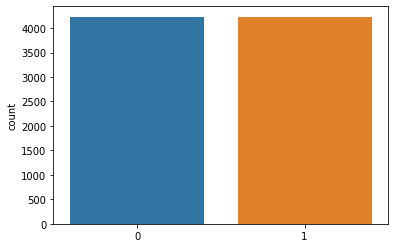

In [45]:
# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())
 
# plotar a nova distribuição de classes
sns.countplot(y_res);

In [46]:
# instanciar e treinar um modelo de Regressão Logística
model_res = DecisionTreeClassifier()
model_res.fit(X_res, y_res)
 
# fazer as previsões em cima dos dados de teste
y_pred_res = model_res.predict(X_test)
y_proba_res = model_res.predict_proba(X_test)
 
# plotar a matrix de confusão
# skplt.metrics.plot_confusion_matrix(y_test, y_pred_res, normalize=True)
 
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_res, digits=4))
 
# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_res)))
 
# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_res)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9284    0.6232    0.7458      7986
           1     0.1828    0.6367    0.2840      1057

    accuracy                         0.6248      9043
   macro avg     0.5556    0.6300    0.5149      9043
weighted avg     0.8412    0.6248    0.6918      9043

Acurácia: 0.6248

AUC: 0.6300



# Cross Validation

In [47]:
# cross validation Decision Tree 
clf = DecisionTreeClassifier(max_depth=7)
clf = clf.fit(X, y)
prediction = clf.predict(X_test)
tam_i = []
for i in prediction[1:]:
  if i == 1:
    tam_i.append(i)
error_valid_clf = (len(tam_i))
print(f"No conjunto de treino X com {X_train.shape[0]}, temos {error_valid_clf} dados classificados errados")

No conjunto de treino X com 36168, temos 288 dados classificados errados


In [48]:
# cross validation Decision Tree 
clf = DecisionTreeClassifier(max_depth=7)
clf = clf.fit(X, y)
prediction = clf.predict(X_test)
tam_i = []
for i in prediction[1:]:
  if i == 1:
    tam_i.append(i)
error_valid_clf = (len(tam_i))
print(f"No conjunto de treino X com {X_train.shape[0]}, temos {error_valid_clf} dados classificados errados")

No conjunto de treino X com 36168, temos 290 dados classificados errados


# Confusion Matrix

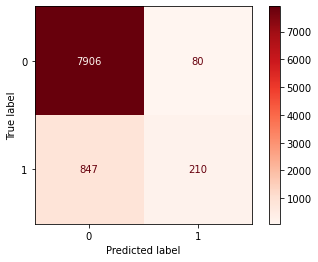

In [56]:
# Matriz de confusão Decision Tree
conf_matrix = plot_confusion_matrix(clf, X_test, y_test, cmap='Reds')

In [57]:
# Matriz de confusão Decision Tree
# conf_matrix = plot_confusion_matrix(clf, X_test_b, y_test_b, cmap='Greens')

## Explicando a matriz de confusão
* Quadrante superior esquerdo = Verdadeiro Positivo<br>
* Quadrante superior direito = Falso Negativo<br>
* Quadrante inferior esquerdo = Falso Positivo<br>
* Quadrante inferior direito = Verdadeiro Negativo


# Curva ROC

A curva ROC avalia o desempenho do modelo a partir da relação entre a taxa de verdadeiros porsitivos (sensibilidade) e a taxa de falsos positivos (especificidade) para diferentes limites.<br><br>
 * SENSIBILIDADE -> métrica que pode ser utilizada é a sensibilidade (também conhecida como recall ou revocação). Essa métrica avalia a capacidade do método de detectar com sucesso resultados classificados como positivos. <br><br>
 * ESPECIFICIDADE -> Avalia a capacidade do método de detectar resultados negativos. 



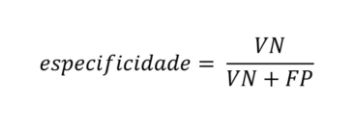

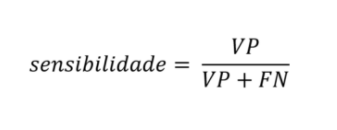

#### Curva ROC Decision Tree

In [58]:
# fpr -> False Positive Rate (taxa de falsos positivos)
# tpr -> True Positive Rate (taxa de verdadeiros positivos)
# veificando a probabilidade do modelo
prob_clf = clf.predict_proba(X_test)[:,1]
fpr, tpr, limit = roc_curve(y_test, prob_clf) # define a curva ROC
roc_dec_tree = roc_auc_score(y_test, prob_clf)
# calculo da area sobre a curva ROC
round(roc_dec_tree, 3)

0.714

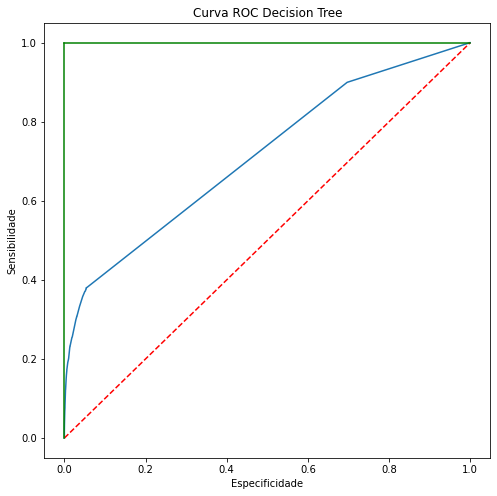

In [59]:
# plotando a curva ROC

plt.subplots(1, figsize=(8,8))
plt.title("Curva ROC Decision Tree")
plt.plot(fpr, tpr)
plt.xlabel('Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls= '--', c = 'red') # plotando linha guia (pontilhada)
plt.plot([0, 0], [1, 0], ls='-', c = 'green'), plt.plot([1, 1], ls='-', c = 'green') # linha guia superior
plt.show()

In [60]:
# fpr -> False Positive Rate (taxa de falsos positivos)
# tpr -> True Positive Rate (taxa de verdadeiros positivos)
# veificando a probabilidade do modelo
prob_clf = clf.predict_proba(X_test_b)[:,1]
fpr, tpr, limit = roc_curve(y_test_b, prob_clf) # define a curva ROC
roc_dec_tree = roc_auc_score(y_test_b, prob_clf)
# calculo da area sobre a curva ROC
round(roc_dec_tree, 3)

0.714

In [61]:
# plotando a curva ROC

# plt.subplots(1, figsize=(8,8))
# plt.title("Curva ROC Decision Tree")
# plt.plot(fpr, tpr)
# plt.xlabel('Especificidade')
# plt.ylabel('Sensibilidade')
# plt.plot([0, 1], ls= '--', c = 'red') # plotando linha guia (pontilhada)
# plt.plot([0, 0], [1, 0], ls='-', c = 'green'), plt.plot([1, 1], ls='-', c = 'green') # linha guia superior
# plt.show()

#### Explicando o gráfico<br>

A linha vermelha (diagonal à direita), representa um modelo aleatório, já a linha verde representa um modelo perfeito, podemos concluir que quanto mais próximo da linha verde, mais correto está a predição do modelo, neste caso nossa linha azul ROC está mais próxima da linha verde.

No gráfico de curva ROC da Linear Regression e Decision Tree, podemos ver as curvas muito parecidas, já no KNN, o desempenho já não é tão bom.

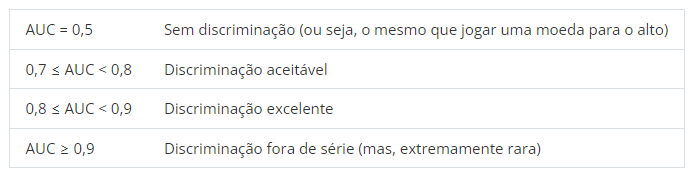


Nosso modelo tem 7.1 de discriminação na curva ROC, ou seja, temos uma discriminação aceitável.